In [1]:
import random
import numpy as np
import qiskit

from functools import reduce
import matplotlib.pyplot as plt

from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import Aer #imported that way for save_statevector to work

from qiskit.circuit.library import MCMT, ry

# Uniform Superposition Generator

Implementation of the algorithm described in [here](https://arxiv.org/pdf/2206.08588.pdf). The paper is called "Efficient Deterministic Preparation of Quantum States Using Decision Diagrams". We only care about creating equal superpositions of states.

In [2]:
def RootNode():
    return {
        "onechild": None,
        "zerochild": None,
        "p0": None,
        "t0": None,
        "t1": None
    }
    
def InternalNode(parent):
    return {
        "parent": parent,
        "onechild": None,
        "zerochild": None,
        "p0": None,
        "t0": None,
        "t1": None
    }

def TerminalNode(parent, amplitude):
    return {
        "parent": parent,
        "amplitude": amplitude,
    }


## Generating the Decision Diagram

In [3]:
def GenerateTree(states):
    """
    Generates a dictionary which represents the tree diagram corresponding to
    the equal superposition state provided
    
    states: represent the equal superposition as an array of states, 
    where each state is represented by a bit string 
    e.g. states = ["00", "11"] represents state 1/sqrt(2)(|00> + |11>)
    
    returns the tree
    """

    treeDiagram = {
        "root": RootNode()
    }

    amplitude = 1/np.sqrt(len(states))

    for state in states:
        curr_node = "root"
        pos_in_tree = ""

        for i in range(len(state)):
            qbit = state[i]
            whichchild = "onechild" if qbit == "1" else "zerochild" if qbit == "0" else "ERROR"
            pos_in_tree += str(qbit)

            # For Internal Nodes (checks whether i is last qubit of state)
            if i != len(state)-1:

                # If node doesn't already exist, create it
                if treeDiagram[curr_node][whichchild] is None:
                    # Adding node to tree
                    new_name = "i"+pos_in_tree
                    new_node = InternalNode(curr_node)
                    treeDiagram[new_name] = new_node

                    # Adding new node as child to current node
                    treeDiagram[curr_node][whichchild] = new_name

                    # Making the child the current node 
                    curr_node = new_name

                # If node already exists
                else:
                    curr_node = treeDiagram[curr_node][whichchild]


            # For Terminal Nodes
            else:
                # If node doesn't already exist, create it
                if treeDiagram[curr_node][whichchild] is None:
                    # Adding node to tree
                    new_name = "t"+pos_in_tree
                    new_node = TerminalNode(curr_node, amplitude)
                    treeDiagram[new_name] = new_node

                    # Adding new node as child to current node
                    treeDiagram[curr_node][whichchild] = new_name
             
    return treeDiagram

def terminal_nodes(tree):
    """
    Returns an array of keys of the tree which 
    correspond to terminal nodes, sorted by name.
    """
    nodes = tree.keys()

    return sorted(list(filter(lambda node: node[0] == "t", nodes)))

## Amplitude propagation in post-order traversal

In [4]:
def nextnearest_postorder(curr_node, tree, visited):
    """
    Meant to be used as a sub-component of function next_postorder.
    
    Returns the name of the node which should come next in Post-order traversal
    among direct neighbours (DN).
    
    Only checks the nodes which are directly connected to curr_node and itself (i.e. direct neighbours).
    If None is returned, then no checked node matched both conditions: exists + not visited.
    In this implementation, it is pressumed to only happen if all nodes of the tree have been 
    visited. If None is obtained and it isn't the case, then these unvisited nodes
    won't ever be in this implementation.
    
    - curr_node: key in tree corresponding to the current node
    - tree: a dictionary representing the BDD
    - visited: a dictionary which has for keys the name of 
    the nodes which have already been visited. 
    """
    curr_dict = tree[curr_node]
    next_node = None

    ### Appending nodes in order of priority according to post-order traversal ###
    priority_order = []
    
        # Avoids error in case we are at leaf
    if "onechild" in curr_dict:
        priority_order.append(curr_dict["onechild"])
    if "zerochild" in curr_dict:
        priority_order.append(curr_dict["zerochild"])

    priority_order.append(curr_node)

        # Avoids error in case we are at root
    if "parent" in curr_dict:
        priority_order.append(curr_dict["parent"])

    ### Finding the next node ###
    for node in priority_order:
        # Check whether node exists + hasn't been visited yet
        if not (node is None) and not (node in visited):
            next_node = node
            break
    
    if next_node is None and curr_node != "root":
        print(f"next_node was None for curr_node = {curr_node}")
        
    return next_node

def next_postorder(curr_node, tree, visited):
    """
    Returns the name of the node which should come next in Post-order traversal,
    across the entire tree.
    
    Post-order traversal has priority order:
    1. first-child node
    2. zero-child node
    3. Current node
    """
    next_node = nextnearest_postorder(curr_node, tree, visited)

    while curr_node != next_node and not next_node is None:
        curr_node = next_node
        next_node = nextnearest_postorder(curr_node, tree, visited)
        
    return next_node

def traversal_postorder(tree, f):
    """
    Performs postorder traversal of the tree, and runs function
    f at each node.
    
    f is called as f(name_of_current_node, tree)
    
    f: function which takes as parameters curr_node, tree
    """
    visited = {}
    curr_node = terminal_nodes(tree)[-1]
    
    while not curr_node is None:
        # run f
        f(curr_node, tree)
        
        # mark node as visited
        visited[curr_node] = None
        
        # get the next node
        curr_node = next_postorder(curr_node, tree, visited)

In [5]:
def compute_prop(child_name, tree):
    """
    Computes and returns the proportion from a given children.
    
    If child is a zero-child, then proportion = t0
    If child is a one-child, then proportion = t1
    
    If child is itself a terminal node, the proportion is its amplitude squared.
    If child is itself a branching node, then proportion is sum of its own t1 and t0
    (which are presumed to have already been computed and stored in tree[child_name])
    """
    child_node = tree[child_name]
    
    # if node is terminal node
    if child_name[0] == "t":
        return child_node["amplitude"]**2
            
    # if node is branching node
    if child_name[0] == "i":
        return child_node["t0"] + child_node["t1"]
        
    raise Error(f"Child name is unrecognized or root, which it shouldn't be: {child_name}")
    
def compute_p0(node_name, tree):
    """
    Computes and stores (in the tree) p0 for the node provided.
    
    Designed for being passed as arg to "traversal_postorder", hence why
    terminal_node case is escaped.
    """
    # Escape if terminal node
    if node_name[0] == "t":
        return
    
    node = tree[node_name]
    children = ["zerochild", "onechild"]
    props = ["t0", "t1"]
    
    for i in range(2):
        child_key = children[i]
        prop_key = props[i]
        child_name = node[child_key]            
        node[prop_key] = 0.0 if child_name is None else compute_prop(child_name, tree)
        
    node["p0"] = node["t0"] / (node["t0"] + node["t1"])

## Circuit generation in pre-order traversal

In [6]:
def nextnearest_preorder(curr_node, tree, visited):
    """
    Meant to be used as a sub-component of function next_preorder.
    
    Returns the name of the node which should come next in Pre-order traversal
    among direct neighbours (DN).
    
    Only checks the nodes which are directly connected to curr_node and itself (i.e. direct neighbours).
    
    If no checked node matches both conditions (i.e. exists + not visisted), then the parent is returned
    instead (if it has one i.e. "root" is the only case where None is returned)
    
    - curr_node: key in tree corresponding to the current node
    - tree: a dictionary representing the BDD
    - visited: a dictionary which has for keys the name of 
    the nodes which have already been visited. 
    """
    curr_dict = tree[curr_node]
    next_node = None

    ### Appending nodes in order of priority according to pre-order traversal ###
    priority_order = []
    
    priority_order.append(curr_node)
    
        # Avoids error in case we are at leaf
    if "onechild" in curr_dict:
        priority_order.append(curr_dict["onechild"])
    if "zerochild" in curr_dict:
        priority_order.append(curr_dict["zerochild"])

    ### Finding the next node ###
    for node in priority_order:
        # Check whether node exists + hasn't been visited yet
        if not (node is None) and not (node in visited):
            next_node = node
            break
    
    # If one of itself, onechild or zerochild existed + was not visited, return it
    if not next_node is None:
        return next_node
    
    # Otherwise, return the parent instead (if it has one, which is always the case except if root)
    return curr_dict["parent"] if "parent" in curr_dict else None

def next_preorder(curr_node, tree, visited):
    """
    Returns the name of the node which should come next in Pre-order traversal,
    across the entire tree.
    
    Pre-order traversal has priority order:
    1. Current node
    2. first-child node
    3. zero-child node
    """
    next_node = nextnearest_preorder(curr_node, tree, visited)

    while curr_node != next_node and not next_node is None:
        curr_node = next_node
        next_node = nextnearest_preorder(curr_node, tree, visited)
        
    return next_node

def traversal_preorder(tree, f, *fargs):
    """
    Performs preorder traversal of the tree, and runs function
    f at each node.
    
    f is called as f(name_of_current_node, tree, isfirsthpath, *fargs)
    
    f: function which takes as parameters curr_node, tree
    circuit: circuit to which the gates should be appended
    f_addargs: additional parameters to be passed to f,
    isfirstpath: a flag which indicates whether we are on the first path of the decision diagram
    """
    visited = {}
    curr_node = "root"
    isfirstpath = True
    
    while not curr_node is None:
        # run f
        f(curr_node, tree, isfirstpath, *fargs)
        
        # mark node as visited
        visited[curr_node] = None
        
        # We take reaching the 1st terminal node to mean it is the end of the 1st path
        if curr_node[0] == "t":
            isfirstpath = False
        
        # get the next node
        curr_node = next_preorder(curr_node, tree, visited)

In [7]:
def get_Ggate(p0):
    """
    Returns a G(p0) gate.
    
    G(p0) is implemented using Pauli-y rotation: 
    $G(p0) = R_y(2*cos(sqrt(p0))^-1)$
    """
    theta = 2*np.arccos(np.sqrt(p0))
    Ry = ry.RYGate(theta, label=f"G({round(p0,2)})")
    
    return Ry

def add_G(circuit, target, p0):
    """
    Appends a G(p0) gate to the circuit
    
    G(p0) is implemented using Pauli-y rotation: 
    $G(p0) = R_y(2*cos(sqrt(p0))^-1)$
    
    target: Qubit
    """
    circuit.append(get_Ggate(p0), [target])

def add_ctrlG(circuit, target, ctrls, zero_ctrls, p0):
    """
    Appends a n-controlled G(p0) gate to the circuit (n = len(ctrls))
    
    G(p0) is implemented using Pauli-y rotation: 
    $G(p0) = R_y(2*cos(sqrt(p0))^-1)$
    
    target: Qubit,
    ctrls: array of Qubits,
    zero_ctrls: a subset of the control qubits. It is those which must be activated
    when the ctrl is 0 instead of 1 (i.e. their control must be sandwiched between two Xs)
    """    
    Ggate = get_Ggate(p0)
    ctrlG = MCMT(Ggate, len(ctrls), 1).to_gate(label=f"{len(ctrls)}-ctrl G({round(p0,2)})")
    
    ctrlG_args = ctrls+[target]
    
    circuit.x(zero_ctrls) if len(zero_ctrls)>0 else _
    circuit.append(ctrlG, ctrlG_args)
    circuit.x(zero_ctrls) if len(zero_ctrls)>0 else _
    

def add_ctrlX(circuit, target, ctrls, zero_ctrls):
    """
    Appends a n-controlled X gate to the circuit (n = len(ctrls))
    
    target: Qubit,
    ctrls: array of Qubits,
    zero_ctrls: a subset of the control qubits. It is those which must be activated
    when the ctrl is 0 instead of 1 (i.e. their control must be sandwiched between two Xs)
    """
    ctrlX = MCMT("x", len(ctrls), 1).to_gate(label=f"{len(ctrls)}-ctrl X")
    ctrlX_args = ctrls+[target]
    
    circuit.x(zero_ctrls) if len(zero_ctrls)>0 else _
    circuit.append(ctrlX, ctrlX_args)
    circuit.x(zero_ctrls) if len(zero_ctrls)>0 else _

def last_onechild(node_name):
    """
    Returns the node which is the last onechild on the path
    of the node provided. 
    
    This can be found from the name of a node as the latter
    is constructed from the path.
    e.g. if node_name = "t01000", last_onechild = "i0"
         if node_name = "i100", last_onechild = "root"
         if node_name = "i01001", last_onechild = "i0100"
    """
    last1_index = None
    name_len = len(node_name)
    name_rev = list(reversed(node_name))
    
    # finds the last "1" in node_name
    for i in range(name_len):
        if name_rev[i] == "1":
            last1_index = name_len - (i+1)
            break

    # if no such element exists -> return None
    if last1_index is None:
        return None
    
    # if last 1 in path has index 1 -> return "root"
    if last1_index == 1:
        return "root"
     
    # else node found must be internal
        # if original node was terminal -> make change "t" to "i"  
    if node_name[0] == "t":
        node_name = "i"+node_name[1:]
        # slice starting at (and including) the last 1
    node_name = node_name[:last1_index]
    
    return node_name

def qubitindex(node_name):
    """
    Returns the index of the qubit from the name of the node it correspond to.
    
    e.g. "root" is q0 (0 is returned), i111 would be q3 (3 is returned)
    
    None is returned if node is a terminal node (i.e. not a qubit)
    """
    if node_name == "root":
        return 0
    
    # if node is an internal node
    if node_name[0] == "i":
        return len(node_name) - 1

def branching_nodes(termnode_name, tree):
    """
    Returns (branching_nodes, branching_nodes_nature)
    where:
    - branching_nodes: the name of all nodes on that terminal node's branch 
    which are branching nodes (i.e. have both a onechild and a zerochild)
    - branching_nodes_nature: a binary string which tells whether each one of 
    these branching nodes is a |0> or |1> on that branch.
    
    termnode_name: must be the name of a terminal node
    """
    branching_nodes = []
    branching_nodes_nature = ""
    
    node_name = tree[termnode_name]["parent"]
    node = tree[node_name]
    
    # removing "t" + reversing as to have a string which gives 
    # whether each node on this branch is a |0> or a |1> in the right order
    termnode_name = termnode_name[1:][::-1]
#     termnode_name = termnode_name[1:] # before last change
    node_index = 0 # index in "termnode_name" of current node in while loop
    
    while True:
        # if node is a branching node -> save name and nature
        if node["onechild"] is not None and node["zerochild"] is not None:
            branching_nodes.append(node_name)
            branching_nodes_nature += termnode_name[node_index]

        # breaking out once we reached the root
        if node_name == "root":
            break
        
        # switching to parent node
        node_name = tree[node_name]["parent"]
        node = tree[node_name]
        node_index += 1
    
    return branching_nodes, branching_nodes_nature


In [8]:
def process_node(curr_name, tree, isfirstpath, circuit, mainqbits, ancqbit):
    """
    Adds to the circuit the gate that corresponds to the node provided,
    as detailed in the paper the algorithm is based upon.
    
    mainqbits: an array of Qubits
    ancqbit: the ancillary Qubit,
    isfirstpath: a bool indicating whether the node to be processed lies on the 
    first path. This is to determine whether we need the ancilla as a ctrl
    """
    curr_node = tree[curr_name]
    curr_index = qubitindex(curr_name)
    
    
    # If node is not terminal & it has a onechild
    if "onechild" in curr_node and curr_node["onechild"] is not None:
        target = mainqbits[curr_index]
        
        # Computing the controls
        ctrls = []
        zero_ctrls = [] # zero ctrls is always empty here because the last_onechild is always a |1>
            # If current path is not the 1st -> Add ancilla
        if not isfirstpath:
            ctrls.append(ancqbit)
            # If, in the branch, there is a previous node with a onechild -> add it
        ctrl_name = last_onechild(curr_name)
        if ctrl_name is not None:
            ctrl_index = qubitindex(ctrl_name)
            ctrls.append(mainqbits[ctrl_index])
        
        # If node is branching -> add ctrlG
        if curr_node["zerochild"] is not None:
            if len(ctrls)<1:
                add_G(circuit, target, curr_node["p0"])
            else:                
                add_ctrlG(circuit, target, ctrls, zero_ctrls, curr_node["p0"])
                
        # If node has only a onechild -> add ctrlX
        else:
            if len(ctrls)<1:
                circuit.x(target)
            else:
                add_ctrlX(circuit, target, ctrls, zero_ctrls)
    
    # If node is terminal
    if curr_name[0] == "t":
        # finding branching nodes and adding them as controls
        brch_names, brch_natures = branching_nodes(curr_name, tree)
        
        # getting corresponding ctrl qubits
        brch_indices = [qubitindex(name) for name in brch_names]
        ctrls = [mainqbits[i] for i in brch_indices]
        
        # getting those ctrl qubits which are |0> (and hence must be 0-ctrl instead of 1-ctrl)
        # (i.e. ctrl is sandwiched by X gates)
        brchzeros_indices = [i for i, x in enumerate(brch_natures) if x == "0"]
        zero_ctrls = [ctrls[i] for i in brchzeros_indices]
        
        target = ancqbit
        add_ctrlX(circuit, target, ctrls, zero_ctrls)
                

## Final superposition generator

In [9]:
def uniform_sup_circuit(states):
    """
    Runs the entire algorithm to build a circuit
    which outputs a uniform superposition state and returns it,
    
    states: array of bitstrings corresponding to the states
    of the equal superposition e.g. ["111", "000", "110"]
    """
    tree = GenerateTree(states)
    traversal_postorder(tree, compute_p0)
    
    n = len(states[0])
    main = qiskit.QuantumRegister(n, name="main")
    anc = qiskit.QuantumRegister(1, name="anc")
    qc = qiskit.QuantumCircuit(anc, main)
    qc.initialize("1", anc)
    
    traversal_preorder(tree, process_node, qc, main, anc)
    
    return tree, qc

## Evaluation

In [10]:
def statevector(qc, label=None):
    """
    Returns the final statevector of the quantum circuit provided
    """
    if label is None:
        label = str(random.randint(1, 1000))
    
    qc.save_statevector(label=label)
    backend = Aer.get_backend('aer_simulator') 
    qc = qiskit.transpile(qc, backend)
    statevector = backend.run(qc).result().data()[label]
#     statevector = result.get_statevector()
    
    return statevector

def evaluate_uniform_sup(qc, expected_states):
    """
    Evaluates whether the statevector obtained corresponds to the 
    equal superposition state expected
    
    statevector: the final Statevector (qiskit class) obtained,
    expected_state: array of bit strings corresponding to 
    the states of the expected equal superposition.
    """
    sv = statevector(qc)
    
    # extracting final state bit-strings & probabilities
    statevector_dict = sv.to_dict()
    final_ampls = list(statevector_dict.values())
    final_probs = np.array(list(map(lambda i: abs(i)**2, final_ampls)))
    final_states = np.array(list(statevector_dict.keys()))

    # discarding small probabilities (presumed due to error)
    keep_indices = np.where(final_probs > 10e-5)[0]
    final_probs = final_probs[keep_indices]
    final_states = final_states[keep_indices]

    # Making final state in right format for comparison the expected final state
    # Done by removing the ancillary bit (assumed to be the 1st one) and reversing the bit string 
    final_states = [state[:-1][::-1] for state in final_states]

    # Checking whether the final states are the same as the expected states
    states_check = set(final_states) == set(expected_states)

    # Checking whether probabilities are all equal
    probs_check = np.allclose(final_probs[0:1], final_probs[1:])
    
    return states_check, probs_check

In [11]:
def binstr(i, length = None):
    """
    Given an int 'i', returns the corresponding binary string
    """
    binstr_ = '{0:b}'.format(i)
    return str((length-len(binstr_))*"0"+binstr_ if length is not None else binstr_)
    return binstr_

def random_states(min_qbits=2, max_qbits=6, max_statecount=12):
    """
    Generates a random set of states 
    """
    state_len = random.randint(min_qbits, max_qbits)
    states_count = random.randint(2, min(2**state_len, max_statecount))
    all_states = np.array(range(0, 2**state_len))
    np.random.shuffle(all_states)

    selected_states = all_states[:states_count]
    selected_states = [binstr(state, state_len) for state in selected_states]
    
    return selected_states


In [12]:
trials = 100
successes = 0

for i in range(trials):
    print(f"{i+1}/{trials}", end="\r")

    states = random_states(min_qbits=2, max_qbits=6, max_statecount=12)
    tree, qc = uniform_sup_circuit(states)

    states_check, probs_check = evaluate_uniform_sup(qc, states)

    if states_check and probs_check:
        successes += 1

print(f"Out of {trials} trials, {round(successes/trials*100, 2)}% were successes")

Out of 100 trials, 100.0% were successes


## Superposition generator as a gate

In [85]:
def uniform_sup_gate(states):
    """
    Returns a gate which, when applied to a vacuum state,
    outputs an uniform superposition of the states in "states".
    
    "states" is an array of bit strings of equal lengths n
    e.g. ["111", "000", "110"], which encodes the state 1/sqrt(3) (|111> + |000> + |110>)
    
    Requires one ancillary qubit, which is the 0th qubit in this gate. 
    This anc. qubit must have |0> as input. 
    """
    tree = GenerateTree(states)
    traversal_postorder(tree, compute_p0)
    
    n = len(states[0])
    main = qiskit.QuantumRegister(n, name="main")
    anc = qiskit.QuantumRegister(1, name="anc")
    qc = qiskit.QuantumCircuit(anc, main, name=f"{n}-qbit Equal Sup.")
    
    # applies x to initialize ancillary qbit to 1
    qc.x(anc)
    traversal_preorder(tree, process_node, qc, main, anc)
    
    return qc.to_gate(label=f"Uniform Sup. Prep.")

# Search Algorithm

## Initial State Preparation

### Ancillary qubits preparation

In [86]:
def add_XNOR(qc, in_qubits, out_qubit):
    """
    Equivalent to the XNOR gate.
    
    Qubits 0 and 1 are input,
    Qubit 2 is the output. It is flipped if inputs are equal, left unchanged otherwise.
    
    (a, b, c) -> (a, b, c + ~(a + b))
    """
    name = "XNOR"
    
    subin = qiskit.QuantumRegister(2, "in")
    subout = qiskit.QuantumRegister(1, "out")
    subqc = qiskit.QuantumCircuit(subin, subout, name=name)
    
    subqc.cx(subin[0], subout[0])
    subqc.cx(subin[1], subout[0])
    subqc.x(subout[0])
    
    qc.append(subqc.to_gate(label=name), in_qubits[:]+[out_qubit])
    
def ancillary_prep_gate(n):
    """
    Applies the XNOR gates to each bit in a and b and stores
    the result in the corresponding ancillary
    """
    name = "Ancillary Prep."
    inner_cells_reg = qiskit.QuantumRegister(n, name="inner_cells")
    outer_cells_reg = qiskit.QuantumRegister(n, name="outer_cells")
    anc = qiskit.QuantumRegister(n, name="anc")
    subqc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc, name=name)
    
    for i in range(n):
        add_XNOR(subqc, [inner_cells_reg[i], outer_cells_reg[i]], anc[i])
    
    return subqc.to_gate(label=name)


## Initial state prep. as gate

In [76]:
def initial_state_gate(inner_cellids, outer_cellids, n):
    """
    Brings a vacuum state to the initial state.
    The initial state consists of:
    - Uniform superposition over states in register "a"
    - Uniform superposition over states in register "b"
    - Ancillary register preparation to reflect the above superpositions
    """
    name = "Initial State Prep."
    inner_cells_reg = qiskit.QuantumRegister(2*n, name="inner_cells")
    outer_cells_reg = qiskit.QuantumRegister(2*n, name="outer_cells")
    anc_oracle = qiskit.AncillaRegister(n, name="anc_oracle")
    # anc_oracle = qiskit.AncillaRegister(2*n, name="anc_oracle")
    anc_sup = qiskit.AncillaRegister(1, name="anc_sup")
    subqc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc_oracle, anc_sup, name=name)
    
    uniform_sup_inner = uniform_sup_gate(inner_cellids)
    uniform_sup_outer = uniform_sup_gate(outer_cellids)
    ancillary_prep = ancillary_prep_gate(n)
    
    subqc.append(uniform_sup_inner, anc_sup[:]+inner_cells_reg[:])
    subqc.append(uniform_sup_outer, anc_sup[:]+outer_cells_reg[:])
    subqc.append(ancillary_prep, inner_cells_reg[n:]+outer_cells_reg[:n]+anc_oracle[:])
    
    return subqc.to_gate(label=name)

## Diffusion operator

### Reflection about vacuum state

In [77]:
def add_phase(qc, qubit, theta):
    """
    Adds a gate which adds a phase to the qubit provided
    
    The qubit is transformed as |psi> -> e^(i theta) |psi>
    """
    name = f"e^(i{round(theta,2)}) I"
    
    # generating gate
    subqc = qiskit.QuantumCircuit(1, name=name)
    subqubit = subqc.qubits[0]
    subqc.p(theta, subqubit)
    subqc.x(subqubit)
    subqc.p(theta, subqubit)
    subqc.x(subqubit)
    
    # appending to quantum circuit
    qc.append(subqc.to_gate(label=name), [qubit])
    
def add_ctrlX(circuit, target, ctrls, zero_ctrls):
    """
    Appends a n-controlled X gate to the circuit (n = len(ctrls))
    
    target: Qubit,
    ctrls: array of Qubits,
    zero_ctrls: a subset of the control qubits. It is those which must be activated
    when the ctrl is 0 instead of 1 (i.e. their control must be sandwiched between two Xs)
    """
    ctrlX = MCMT("x", len(ctrls), 1).to_gate(label=f"{len(ctrls)}-ctrl X")
    ctrlX_args = ctrls+[target]
    
    circuit.x(zero_ctrls) if len(zero_ctrls)>0 else _
    circuit.append(ctrlX, ctrlX_args)
    circuit.x(zero_ctrls) if len(zero_ctrls)>0 else _
    
def add_vacuumreflection(qc, qubits):
    """
    Adds a gate which reflects a n-qbit registery
    about the vacuum state (i.e. |00...0>). The qubits
    concerned are provided as an array in "qubits"
    
    Implementation from "https://arxiv.org/pdf/quant-ph/0301079.pdf" page 24
    
    It is constructed as X*ctrlZ*X where:
    - X gates are applied to all n qubits
    - ctrlZ has the (n-1) first qubits as ctrls and the last qubit as target.
    
    This is equivalent to both:
    - the transformation U = 2|0><0| - I (where I is the identity),
    - A (2^n,2^n)-diagonal matrix U with <0|U|0> = 1, <i|U|i> = -1 (i≠0)
    """
    name = f"Vacuum Reflection"
    
    # generating gate
    subqc = qiskit.QuantumCircuit(len(qubits), name=name)
    subqubits = subqc.qubits
    
    for qbit in subqubits:
        subqc.x(qbit)   
        
    add_phase(subqc, subqubits[0], np.pi/2)
    subqc.h(subqubits[-1])
    
    add_ctrlX(subqc, subqubits[-1], subqubits[:-1], []) 
    
    add_phase(subqc, subqubits[0], np.pi/2)
    subqc.h(subqubits[-1])
    
    for qbit in subqubits:
        subqc.x(qbit)
    
    # appending to quantum circuit
    qc.append(subqc.to_gate(label=name), qubits)
        

### Diffusion operator as gate

In [78]:
def add_diffusion(qc, inner_cells_reg, outer_cells_reg, anc_oracle, anc_sup, init_state_gate):
    """
    Returns the diffusion gate for the provided initial state.
    
    The diffusion gate is a reflection about this initial state.
    
    Requires one ancillary qubit (the 0th qubit)
    
    - qc: The quantum circuit
    - qubits: array of qubits for the diffusion
    - anc_qubit: an ancillary qubit
    - init_state_gate: a gate generated by the function initial_state_gate()
    """
    input_and_anc = inner_cells_reg[:]+outer_cells_reg[:]+anc_oracle[:]
    
    qc.append(init_state_gate.inverse(), input_and_anc+anc_sup[:])
    add_vacuumreflection(qc, input_and_anc)
    qc.append(init_state_gate, input_and_anc+anc_sup[:])

## Oracle operator

In [79]:
def add_oraclef(qc, ancqbits, outqbit):
    """
    F function of the oracle. Takes as input the ancillary register
    of the initial state and flips the output qubit iif they are
    all in state |1>
    
    Equivalent to a n-Controlled X gate.
    
    num_ctrl is the number of control qubits.
    Qubit 0 is the target, and qubits 1 to n are the control.
    
    (b, a_1, a_2, ..., a_n) -> (b + a_1^a_2^...a_n, a_1, a_2, ..., a_n)
    """
    name = r"Oracle ($U_F$)"
    n = len(ancqbits)
    subqc = MCMT("x", num_ctrl_qubits=n, num_target_qubits=1)
    qc.append(subqc.to_gate(label=name), ancqbits[:]+outqbit[:])

## Grover Iteration (Rotation Operator)

In [80]:
def add_grover_iter(qc, init_state_gate, n):
    """
    Adds a Grover iteration to the circuit.
    
    qbits is a dict containing qubits. It has form:
    qbits = {
        "cells_inner": Array<Qubit> of size 2n, 
        "cells_outer": Array<Qubit> of size 2n,
        "anc_diff": Qubit,
        "anc_oracle": Array<Qubit> of size n,
        "out": Qubit
    }
    """
    name = "Grover iter."
    
    # Generating sub circuit
    inner_cells_reg = qiskit.QuantumRegister(2*n)
    outer_cells_reg = qiskit.QuantumRegister(2*n)
    anc_sup = qiskit.AncillaRegister(1)
    anc_oracle = qiskit.AncillaRegister(n)
    # anc_oracle = qiskit.AncillaRegister(2*n)
    out = qiskit.QuantumRegister(1)
    subqc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc_sup, anc_oracle, out, name=name)
    
    # adding oracle and diffusion gates
    add_oraclef(subqc, anc_oracle, out)
    add_diffusion(subqc, inner_cells_reg, outer_cells_reg, anc_oracle, anc_sup, init_state_gate)
    
    all_qbits = get_ordered_qubits(qc, ["inner_cells", "outer_cells", "superposition_ancillary", "oracle_ancillary", "out"])
    qc.append(subqc.to_gate(label=name), all_qbits)

# Quantum Amplitude Amplification Circuit

In [82]:
def QAA_circuit(inner_cellids, outer_cellids, grover_iters, n):
    """
    Circuit for Quantum Amplitude Amplification (QAA) for finding elements between
    two detector layers which match the connectivity condition.
    
    - inner_cellids: array of cell IDs of the set of all cells in layer l
    - states_b: array of cell IDs of the set of all cells in layer l+1
    - grover_iters: Number of Grover iterations
    - n: bit-size of hit IDs
    
    (note a cell ID is the concatenation of the IDs of the inner and outer hit
    that make up the cell.)
    """
    inner_cells_reg = qiskit.QuantumRegister(2*n, name="inner_cells")
    outer_cells_reg = qiskit.QuantumRegister(2*n, name="outer_cells")
    anc_oracle = qiskit.AncillaRegister(n, name="oracle_ancillary")
    # anc_oracle = qiskit.AncillaRegister(2*n, name="anc_oracle")
    anc_sup = qiskit.AncillaRegister(1, name="superposition_ancillary")
    output = qiskit.QuantumRegister(1, name="out")
    qc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc_sup, anc_oracle, output)
    
    # generating a gate which does vacuum state -> initial state
    init_state_gate = initial_state_gate(inner_cellids, outer_cellids, n)
    
    # initializing the circuit
    qc.append(init_state_gate, inner_cells_reg[:]+outer_cells_reg[:]+anc_oracle[:]+anc_sup[:])
    
    # Putting output in state |-> for phase kickback
#     qc.x(output)
#     qc.h(output)
    
#     qc.barrier()

#     # Grover iterations
#     for i in range(grover_iters):
#         add_grover_iter(qc, init_state_gate, n)  
        
#     qc.barrier()

#     qc.h(output)
#     qc.x(output)
    
    return qc
    

In [42]:
def add_only_oracle_iter(qc, init_state_gate, n):
    """
    Adds a Grover iteration to the circuit.
    
    qbits is a dict containing qubits. It has form:
    qbits = {
        "cells_inner": Array<Qubit> of size 2n, 
        "cells_outer": Array<Qubit> of size 2n,
        "anc_diff": Qubit,
        "anc_oracle": Array<Qubit> of size n,
        "out": Qubit
    }
    """
    name = "Grover iter."
    
    # Generating sub circuit
    inner_cells_reg = qiskit.QuantumRegister(2*n)
    outer_cells_reg = qiskit.QuantumRegister(2*n)
    anc_sup = qiskit.AncillaRegister(1)
    anc_oracle = qiskit.AncillaRegister(n)
    # anc_oracle = qiskit.AncillaRegister(2*n)
    out = qiskit.QuantumRegister(1)
    subqc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc_sup, anc_oracle, out, name=name)
    
    # adding oracle and diffusion gates
    add_oraclef(subqc, anc_oracle, out)
    # add_diffusion(subqc, inner_cells_reg, outer_cells_reg, anc_oracle, anc_sup, init_state_gate)
    
    all_qbits = get_ordered_qubits(qc, ["inner_cells", "outer_cells", "superposition_ancillary", "oracle_ancillary", "out"])
    qc.append(subqc.to_gate(label=name), all_qbits)

def QAA_circuit_halfiters(states_a, states_b, grover_iters, n):
    """
    Circuit for Quantum Amplitude Amplification (QAA) for finding elements between
    two detector layers which match the connectivity condition.
    
    - states_a: array of cell IDs of the set of all cells in layer l
    - states_b: array of cell IDs of the set of all cells in layer l+1
    - grover_iters: Number of Grover iterations
    - n: bit-size of hit IDs
    
    (note a cell ID is the concatenation of the IDs of the inner and outer hit
    that make up the cell.)
    """
    inner_cells_reg = qiskit.QuantumRegister(2*n, name="inner_cells")
    outer_cells_reg = qiskit.QuantumRegister(2*n, name="outer_cells")
    anc_oracle = qiskit.AncillaRegister(n, name="oracle_ancillary")
    # anc_oracle = qiskit.AncillaRegister(2*n, name="anc_oracle")
    anc_sup = qiskit.AncillaRegister(1, name="superposition_ancillary")
    output = qiskit.QuantumRegister(1, name="out")
    qc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc_sup, anc_oracle, output)

    # generating a gate which does vacuum state -> initial state
    init_state_gate = initial_state_gate(states_a, states_b, n)

    # initializing the circuit
    qc.append(init_state_gate, inner_cells_reg[:]+outer_cells_reg[:]+anc_oracle[:]+anc_sup[:])

    # Putting output in state |-> for phase kickback
    qc.x(output)
    qc.h(output)

    # Grover iterations
    for i in range(grover_iters):
        add_grover_iter(qc, init_state_gate, n)
    add_only_oracle_iter(qc, init_state_gate, n)

    qc.h(output)
    qc.x(output)
    
    return qc

# Testing and Troubleshooting

In [43]:
def binary_length(hit_id):
    """
    Provided (non-binary) hit_id, returns its length if it were binary
    """
    return int(np.ceil(np.log2(hit_id+1)))

def binary_str(i, length = None):
    """
    Given an int 'i', returns the corresponding binary string
    """
    binstr_ = '{0:b}'.format(i)
    return str((length-len(binstr_))*"0"+binstr_ if length is not None else binstr_)
    return binstr_

def binary_cells(cells, max_hit_length):
    """
    Converts an array of cells to its analogue with hit ids in binary 
    """
    binary_cells = []
    
    for i in range(len(cells)):
        binary_cells.append([])
        for j in range(2):
            binary_cell = binary_str(cells[i, j], max_hit_length)
            binary_cells[-1].append(binary_cell)
            
    return np.array(binary_cells)


def binary_cellids(cells, max_hit_id):
    """
    Converts an array of cells to an array of binary strings representing those cells.
    
    Each binary string is the concatenation of the two hit IDs that make up that cell,
    in binary.
    """
    return [cell[0]+cell[1] for cell in binary_cells(cells, binary_length(max_hit_id))]

def get_register(qc, reg_label):
    """
    Returns the first quantum register with label "reg_label" in quantum circuit "qc"
    """
    return next((reg for reg in qc.qregs if reg.name == reg_label), None)


def get_ordered_qubits(qc, reg_labels):
    """
    Returns an array of qubits in "qc" sorted per the array of register labels "reg_labels"
    """
    # Filter out registers not in "reg_labels"
    filtered_regs = filter(lambda qreg: qreg.name in labels_dict, qc.qregs)
    
    # array of quantum registers sorted per "reg_labels" order
    labels_dict = {reg_labels[i]: i for i in  range(len(reg_labels))}
    sorted_regs = sorted(filtered_regs, key=lambda reg: labels_dict[reg.name])
    
    # array of corresponding qubits 
    return list(reduce(lambda curr_reg, new_reg: curr_reg[:]+new_reg[:], sorted_regs))   

In [44]:
# inner_cells = np.array([[0, 3], [1, 3],[1, 4],[2, 5],[3, 5]])
# outer_cells = np.array([[3, 7], [3, 6], [5, 7]])
inner_cells = np.array([[0, 2], [1, 2]])
outer_cells = np.array([[2, 4], [3, 4]])
# max_hit_id = 7
max_hit_id = 4

n = binary_length(max_hit_id)
inner_cellids = binary_cellids(inner_cells, max_hit_id)
outer_cellids = binary_cellids(outer_cells, max_hit_id)
print("inner_cellids", inner_cellids)
print("outer_cellids", outer_cellids)

inner_cellids ['000010', '001010']
outer_cellids ['010100', '011100']


In [45]:
grover_iters = 2
qaa_qc = QAA_circuit(inner_cellids, outer_cellids, grover_iters, n)

# grover_iters_arr = np.arange(5, dtype=int)
# states_arr = []
# for grover_iters in grover_iters_arr:
#     print(f"Iter {grover_iters}")
#     qaa_qc = QAA_circuit(inner_cellids, outer_cellids, grover_iters, n)
    
#     states_arr.append(get_state_in_2D(qaa_qc))

In [46]:
print("***Input States***")
print("inner_cellids", inner_cellids)
print("outer_cellids", outer_cellids)
print()

sv = statevector(qaa_qc)
sv_dict = sv.to_dict()

print("***Output states***")

for key, val in sv_dict.items():
    if np.abs(val) < 10e-5:
        continue
    # reversing string to usual way
    key = key[::-1]
    
    print(key)
    
    print("input a", get_str(qaa_qc, "inner_cells", key))
    print("Input b", get_str(qaa_qc, "outer_cells", key))
    print("Anc. oracle", get_str(qaa_qc, "anc_oracle", key))
    print("Anc. sup.", get_str(qaa_qc, "anc_sup", key))
    print("out", get_str(qaa_qc, "out", key))
    print("Ampl.", val)
    print()

***Input States***
inner_cellids ['000010', '001010']
outer_cellids ['010100', '011100']

***Output states***
00001001110001100
input a 000010
Input b 011100


TypeError: list indices must be integers or slices, not NoneType

# Visualizing action of QAA in 2D Hilbert space

In [47]:
def get_reg_names(qc):
    """
    Returns the label of all registers in "qc"
    """
    return [reg.name for reg in qc.qregs]

def get_str_indices(qc, reg_label):
    """
    Returns the bounds of the indices of the qubits of the register with name "reg_label"
    in a statevector of quantum circuit "qc"
    """
    reg_index = next((i for i in range(len(qc.qregs)) if qc.qregs[i].name == reg_label), None)
    
    # these are the indices if Qiskit's string output wasn't reversed
    start_index = sum(map(lambda reg: len(reg), qc.qregs[:reg_index]))
    end_index = start_index + len(qc.qregs[reg_index])
    
    
    return start_index, end_index

def get_str(qc, reg_label, state):
    
    start_index, end_index = get_str_indices(qc, reg_label)
    
    return state[start_index:end_index]

def get_state_in_2D(qc):
    """
    Returns the statevector representation of the final state of "qc"
    in the 2D Hilbert space spanned by |M> and |M^perp>, where |M> is the
    uniform superposition over all the states which are solutions, while
    |M^perp> is a uniform superposition over the rest of the states.
    """

    # Extract the final state vector of the QAA circuit
    sv = statevector(qc)
    sv_dict = sv.to_dict()

    # Find the set of true solution states 
    sol_states = []
    for i in range(len(inner_cellids)):
        for j in range(len(outer_cellids)):
            # if inner_cellids[i] == outer_cellids[j]:
            if inner_cellids[i][n:] == outer_cellids[j][:n]:
                sol_states.append(inner_cellids[i]+ outer_cellids[j])


    # Gather the amplitudes of the solution states in the output
    idx_a = get_str_indices(qc, "inner_cells")
    idx_b = get_str_indices(qc, "outer_cells")
    sol_ampls_dict = {}
    sv_states = list(sv_dict.keys())
    sv_ampls = list(sv_dict.values())
    for sol_state in sol_states:
        ampls = [] 
        for state, ampl in sv_dict.items():
            state = state[::-1]
            str_a = state[idx_a[0]:idx_a[1]]
            str_b = state[idx_b[0]:idx_b[1]]

            if str_a+str_b == sol_state:
                ampls.append(ampl)

        sol_ampls_dict[sol_state] = sum(ampls)


    # Find the vector representation of the output
    # in the 2D Hilbert space spanned by M and M^perp
        # amplitude of each solution state for a uniform superposition of them
        # that is, the |psi_M> state
    psi_M_ampl = 1/np.sqrt(len(sol_states))
    sol_ampls = np.array(list(sol_ampls_dict.values()))
    print("sol_ampls", sol_ampls.real)
    inner_prod = np.sum(psi_M_ampl*sol_ampls).real
    theta = np.arcsin(inner_prod)
    state = [np.cos(theta), np.sin(theta)]
    
    return state

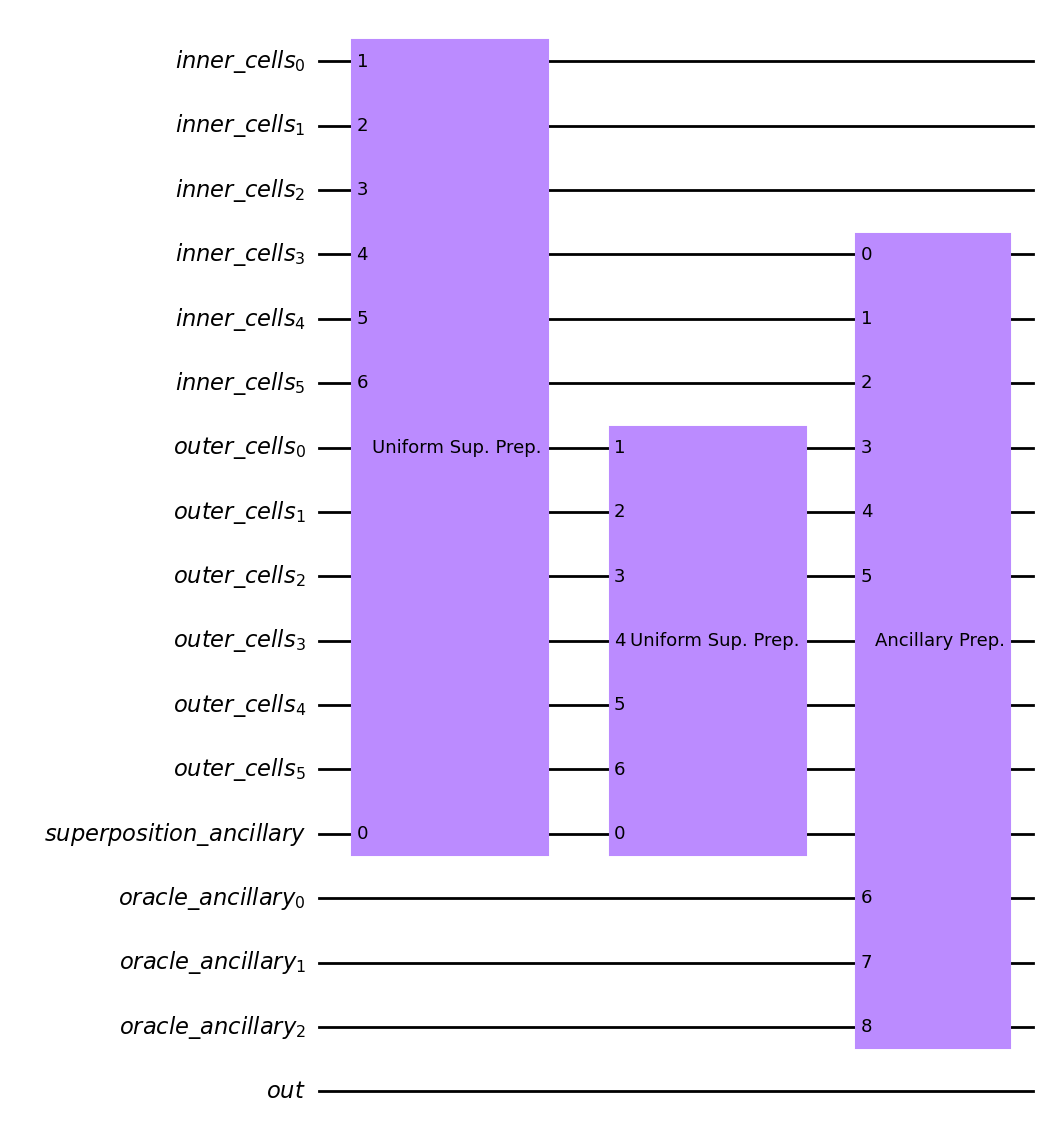

In [88]:
inner_cells = np.array([[0, 3], [1, 3],[1, 4],[2, 5],[3, 5]])
# outer_cells = np.array([[0, 3], [3, 6], [5, 7]]) # hit-only searching
outer_cells = np.array([[3, 7], [3, 6], [5, 7]]) # cell searching
max_hit_id = 7

n = binary_length(max_hit_id)
inner_cellids = binary_cellids(inner_cells, max_hit_id)
outer_cellids = binary_cellids(outer_cells, max_hit_id)
grover_iters_arr = np.arange(4, dtype=int)

qaa_qc = QAA_circuit(inner_cellids, outer_cellids, i+1, n)
qaa_qc.decompose().draw(output="mpl")

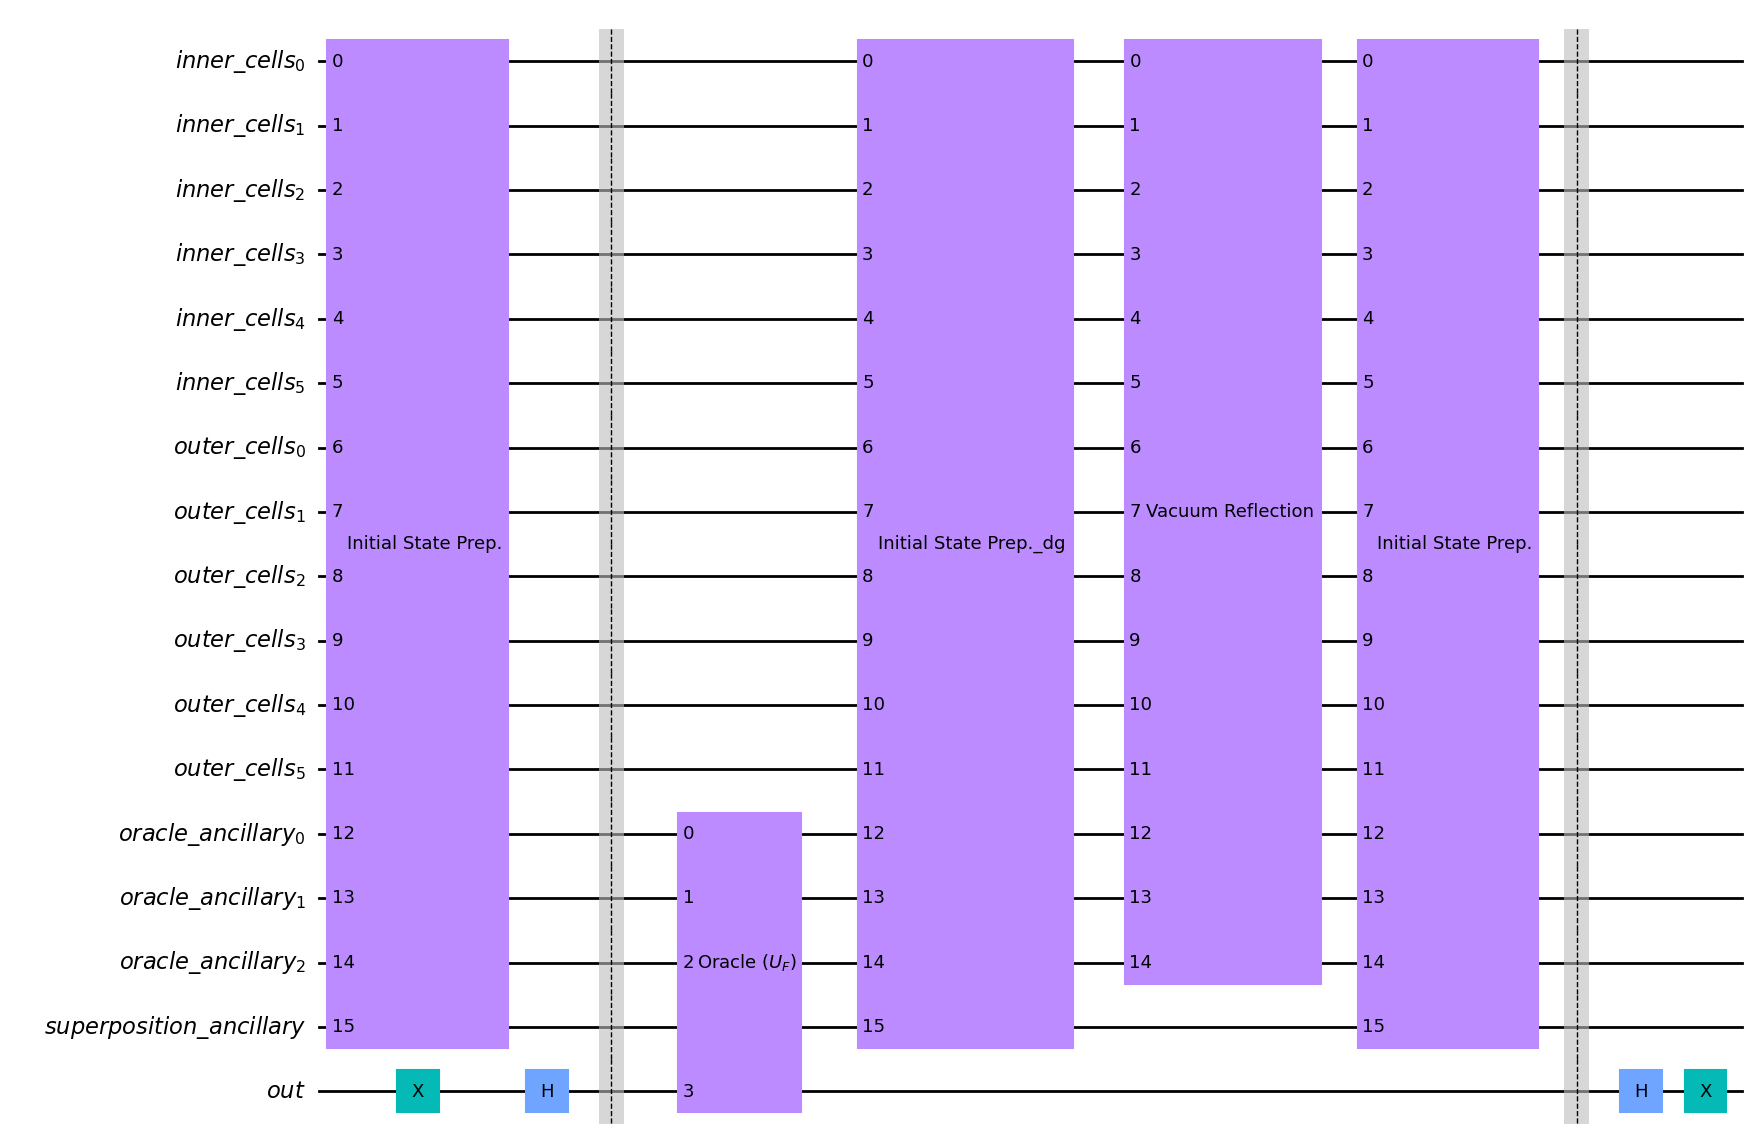

In [81]:
inner_cells = np.array([[0, 3], [1, 3],[1, 4],[2, 5],[3, 5]])
# outer_cells = np.array([[0, 3], [3, 6], [5, 7]]) # hit-only searching
outer_cells = np.array([[3, 7], [3, 6], [5, 7]]) # cell searching
max_hit_id = 7

n = binary_length(max_hit_id)
inner_cellids = binary_cellids(inner_cells, max_hit_id)
outer_cellids = binary_cellids(outer_cells, max_hit_id)
grover_iters_arr = np.arange(4, dtype=int)

qaa_qc = QAA_circuit(inner_cellids, outer_cellids, i+1, n)
qaa_qc.decompose(["Grover iter."]).draw(output="mpl")

In [52]:
inner_cells = np.array([[0, 3], [1, 3],[1, 4],[2, 5],[3, 5]])
# outer_cells = np.array([[0, 3], [3, 6], [5, 7]]) # hit-only searching
outer_cells = np.array([[3, 7], [3, 6], [5, 7]]) # cell searching
max_hit_id = 7

n = binary_length(max_hit_id)
inner_cellids = binary_cellids(inner_cells, max_hit_id)
outer_cellids = binary_cellids(outer_cells, max_hit_id)
grover_iters_arr = np.arange(4, dtype=int)


states_arr = []
for i in range(0, 1):
    qaa_qc = QAA_circuit(inner_cellids, outer_cellids, i, n)
    states_arr.append(get_state_in_2D(qaa_qc))
    
    qaa_qc = QAA_circuit_halfiters(inner_cellids, outer_cellids, i, n)
    states_arr.append(get_state_in_2D(qaa_qc))
    
qaa_qc = QAA_circuit(inner_cellids, outer_cellids, i+1, n)
states_arr.append(get_state_in_2D(qaa_qc))

grover_iters_arr = np.arange(len(states_arr), dtype=int)

sol_ampls [0.25819889 0.25819889 0.25819889 0.25819889 0.25819889 0.25819889]
sol_ampls [-0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889]
sol_ampls [0.36147845 0.36147845 0.36147845 0.36147845 0.36147845 0.36147845]


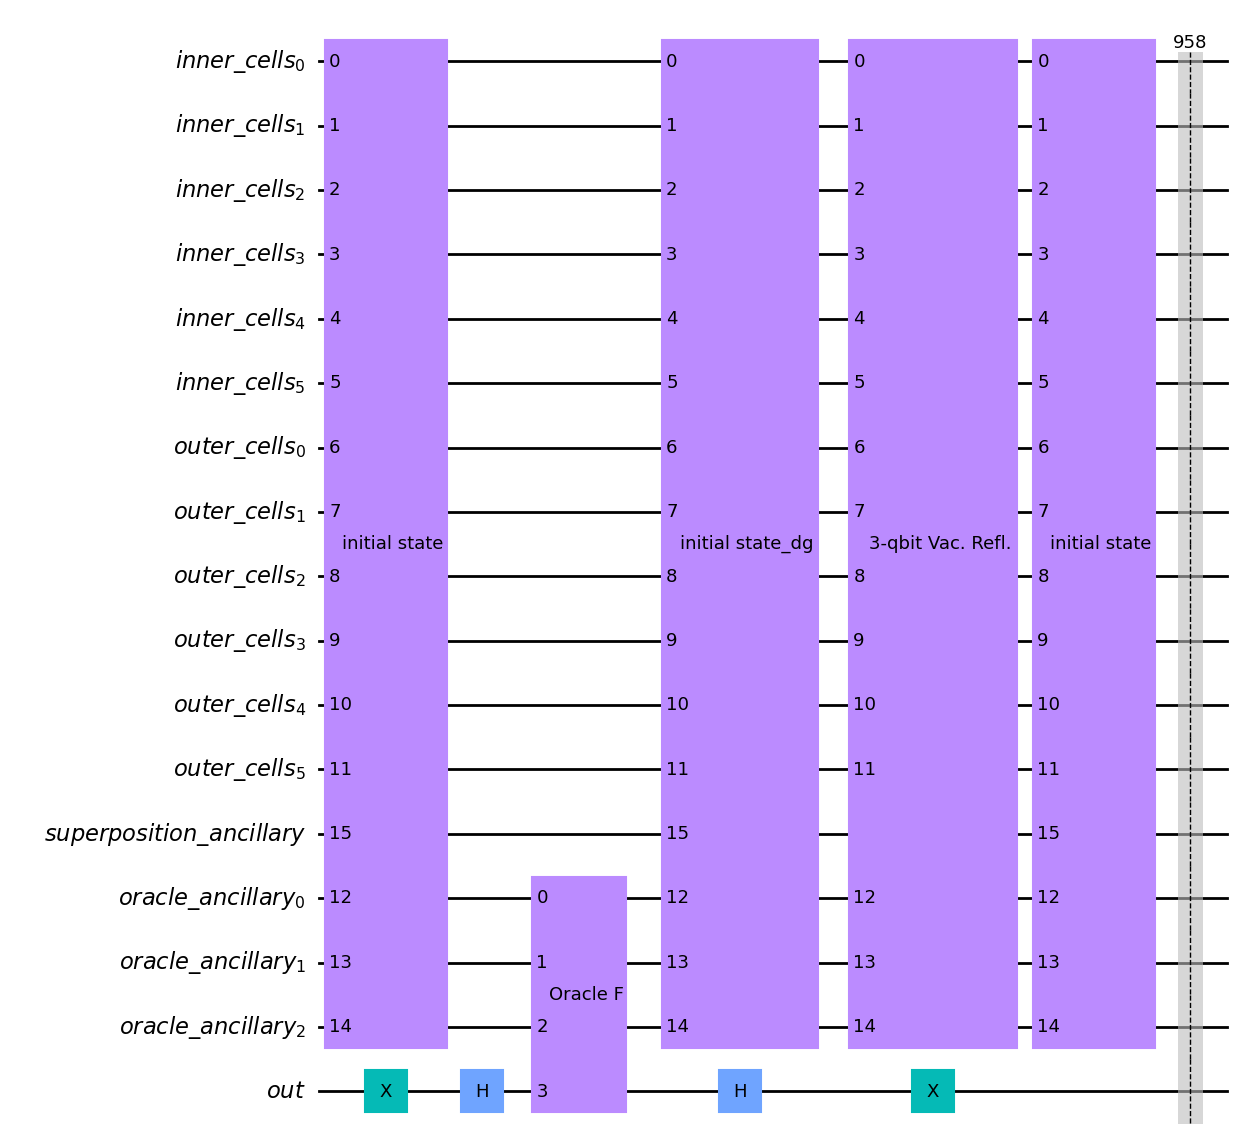

In [ ]:
M = [0, 1]
M_perp = [1, 0]
delta = 0.05
origin = np.array([[0, 0, 0],[0, 0, 0]])
colors = plt.cm.get_cmap("Blues")(np.linspace(0.3, 1, len(states_arr)))

plt.figure(figsize=(6, 6))
QM = plt.quiver(*origin, *M, color="black", angles='xy', scale_units='xy', scale=1, width=0.01)
QM_perp = plt.quiver(*origin, *M_perp, color="black", angles='xy', scale_units='xy', scale=1, width=0.01)
plt.text(M[0]-0.2, M[1]-0.1, r'$|\psi_M \rangle$')
plt.text(M_perp[0]-0.2, M_perp[1]-0.1, r'$|\psi_{M^{\perp}} \rangle$')

for i in range(len(grover_iters_arr)):
    Qstate = plt.quiver(*origin, *states_arr[i], color=colors[i], angles='xy', scale_units='xy', scale=1)
    
    bs = "\\"
    if i == 0:
        label = f'$ | {bs}psi_X {bs}rangle$'
        
    elif i == 1:
        label = f'$Ô | {bs}psi_X {bs}rangle$'
        
    elif i == 2:
        label = f'${bs}hat{{G}} | {bs}psi_X {bs}rangle$'
        
    elif i == 3:
        label = f'$Ô {bs}hat{{G}} | {bs}psi_X {bs}rangle$'
        
        
    elif i%2 == 0:
        k = int(grover_iters_arr[i]/2)
        label = f'${bs}hat{{G}}^{k} | {bs}psi_X {bs}rangle$'
        
    else:
        k=int((grover_iters_arr[i]-1)/2)        
        label = f'$Ô {bs}hat{{G}}^{k} |{bs}psi_X {bs}rangle$'
    plt.text(states_arr[i][0]*1.05, states_arr[i][1]*1.05, label)

plt.ylim(-1.2, 1.2)
plt.xlim(-1.2, 1.4)
plt.grid()
# plt.xlabel(r'$|\psi_{M^{\perp}} \rangle$')
# plt.ylabel(r'$|\psi_{M} \rangle$')
plt.show()

In [ ]:
def get_angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))

print(get_angle(states_arr[1], states_arr[3]))
print(get_angle(states_arr[4], states_arr[1]))
print(get_angle(states_arr[5], states_arr[0]))
print(get_angle(states_arr[2], states_arr[0]))
print(get_angle(states_arr[5], np.array([1, 0])))
print(get_angle(states_arr[4], np.array([1, 0])))
print(get_angle(states_arr[5], states_arr[4]))

print(get_angle(states_arr[5], np.array([1, 0])))
It looks like for some reason the diffusion operator does a reflection about the reflection of the initial state in the psi_M^perp axis, rather than about the initial state itself. That is, the reflection axis is 

I know that it works if the ancillary prep acts on all of the inputs, i.e., if it checks whether all of them are equal, i.e. if we are looking at two superpositions of hits rather than cells. It might have to do with the entanglement again, just like i

It looks like it is the diffusion operator that doesn't work properly. In this particular instance, it seems to just perform a reflection about the |M_perp> state.

# Testing with only two hit registers (instead of two cell)

In [189]:
def initial_state_gate(inner_cellids, outer_cellids, n):
    """
    Brings a vacuum state to the initial state.
    The initial state consists of:
    - Uniform superposition over states in register "a"
    - Uniform superposition over states in register "b"
    - Ancillary register preparation to reflect the above superpositions
    """
    name = "initial state"
    inner_cells_reg = qiskit.QuantumRegister(2*n, name="inner_cells")
    outer_cells_reg = qiskit.QuantumRegister(2*n, name="outer_cells")
    # anc_oracle = qiskit.AncillaRegister(n, name="anc_oracle")
    anc_oracle = qiskit.AncillaRegister(2*n, name="anc_oracle")
    anc_sup = qiskit.AncillaRegister(1, name="anc_sup")
    subqc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc_oracle, anc_sup, name=name)
    
    uniform_sup_inner = uniform_sup_gate(inner_cellids)
    uniform_sup_outer = uniform_sup_gate(outer_cellids)
    ancillary_prep = ancillary_prep_gate(2*n)
    # ancillary_prep = ancillary_prep_gate(n)
    
    subqc.append(uniform_sup_inner, anc_sup[:]+inner_cells_reg[:])
    subqc.append(uniform_sup_outer, anc_sup[:]+outer_cells_reg[:])
    subqc.append(ancillary_prep, inner_cells_reg[:]+outer_cells_reg[:]+anc_oracle[:])
    # subqc.append(ancillary_prep, inner_cells_reg[n:]+outer_cells_reg[:n]+anc_oracle[:])
    
    return subqc.to_gate(label=name)

def add_grover_iter(qc, init_state_gate, n):
    """
    Adds a Grover iteration to the circuit.
    
    qbits is a dict containing qubits. It has form:
    qbits = {
        "cells_inner": Array<Qubit> of size 2n, 
        "cells_outer": Array<Qubit> of size 2n,
        "anc_diff": Qubit,
        "anc_oracle": Array<Qubit> of size n,
        "out": Qubit
    }
    """
    name = "Grover iter."
    
    # Generating sub circuit
    inner_cells_reg = qiskit.QuantumRegister(2*n)
    outer_cells_reg = qiskit.QuantumRegister(2*n)
    anc_sup = qiskit.AncillaRegister(1)
    # anc_oracle = qiskit.AncillaRegister(n)
    anc_oracle = qiskit.AncillaRegister(2*n)
    out = qiskit.QuantumRegister(1)
    subqc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc_sup, anc_oracle, out, name=name)
    
    # adding oracle and diffusion gates
    add_oraclef(subqc, anc_oracle, out)
    add_diffusion(subqc, inner_cells_reg, outer_cells_reg, anc_oracle, anc_sup, init_state_gate)
    
    all_qbits = get_ordered_qubits(qc, ["inner_cells", "outer_cells", "anc_sup", "anc_oracle", "out"])
    qc.append(subqc.to_gate(label=name), all_qbits)
    
def QAA_circuit(inner_cellids, outer_cellids, grover_iters, n):
    """
    Circuit for Quantum Amplitude Amplification (QAA) for finding elements between
    two detector layers which match the connectivity condition.
    
    - inner_cellids: array of cell IDs of the set of all cells in layer l
    - states_b: array of cell IDs of the set of all cells in layer l+1
    - grover_iters: Number of Grover iterations
    - n: bit-size of hit IDs
    
    (note a cell ID is the concatenation of the IDs of the inner and outer hit
    that make up the cell.)
    """
    inner_cells_reg = qiskit.QuantumRegister(2*n, name="inner_cells")
    outer_cells_reg = qiskit.QuantumRegister(2*n, name="outer_cells")
    # anc_oracle = qiskit.AncillaRegister(n, name="anc_oracle")
    anc_oracle = qiskit.AncillaRegister(2*n, name="anc_oracle")
    anc_sup = qiskit.AncillaRegister(1, name="anc_sup")
    output = qiskit.QuantumRegister(1, name="out")
    qc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc_sup, anc_oracle, output)
    
    # generating a gate which does vacuum state -> initial state
    init_state_gate = initial_state_gate(inner_cellids, outer_cellids, n)
    
    # initializing the circuit
    qc.append(init_state_gate, inner_cells_reg[:]+outer_cells_reg[:]+anc_oracle[:]+anc_sup[:])

    # Putting output in state |-> for phase kickback
    qc.x(output)
    qc.h(output)

    # Grover iterations
    for i in range(grover_iters):
        add_grover_iter(qc, init_state_gate, n)    

    qc.h(output)
    qc.x(output)
    
    return qc

def add_only_oracle_iter(qc, init_state_gate, n):
    """
    Adds a Grover iteration to the circuit.
    
    qbits is a dict containing qubits. It has form:
    qbits = {
        "cells_inner": Array<Qubit> of size 2n, 
        "cells_outer": Array<Qubit> of size 2n,
        "anc_diff": Qubit,
        "anc_oracle": Array<Qubit> of size n,
        "out": Qubit
    }
    """
    name = "Grover iter."
    
    # Generating sub circuit
    inner_cells_reg = qiskit.QuantumRegister(2*n)
    outer_cells_reg = qiskit.QuantumRegister(2*n)
    anc_sup = qiskit.AncillaRegister(1)
    # anc_oracle = qiskit.AncillaRegister(n)
    anc_oracle = qiskit.AncillaRegister(2*n)
    out = qiskit.QuantumRegister(1)
    subqc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc_sup, anc_oracle, out, name=name)
    
    # adding oracle only
    add_oraclef(subqc, anc_oracle, out)
    
    all_qbits = get_ordered_qubits(qc, ["inner_cells", "outer_cells", "anc_sup", "anc_oracle", "out"])
    qc.append(subqc.to_gate(label=name), all_qbits)

def QAA_circuit_halfiters(states_a, states_b, grover_iters, n):
    """
    Circuit for Quantum Amplitude Amplification (QAA) for finding elements between
    two detector layers which match the connectivity condition.
    
    - states_a: array of cell IDs of the set of all cells in layer l
    - states_b: array of cell IDs of the set of all cells in layer l+1
    - grover_iters: Number of Grover iterations
    - n: bit-size of hit IDs
    
    (note a cell ID is the concatenation of the IDs of the inner and outer hit
    that make up the cell.)
    """
    inner_cells_reg = qiskit.QuantumRegister(2*n, name="inner_cells")
    outer_cells_reg = qiskit.QuantumRegister(2*n, name="outer_cells")
    # anc_oracle = qiskit.AncillaRegister(n, name="anc_oracle")
    anc_oracle = qiskit.AncillaRegister(2*n, name="anc_oracle")
    anc_sup = qiskit.AncillaRegister(1, name="anc_sup")
    output = qiskit.QuantumRegister(1, name="out")
    qc = qiskit.QuantumCircuit(inner_cells_reg, outer_cells_reg, anc_sup, anc_oracle, output)

    # generating a gate which does vacuum state -> initial state
    init_state_gate = initial_state_gate(states_a, states_b, n)

    # initializing the circuit
    qc.append(init_state_gate, inner_cells_reg[:]+outer_cells_reg[:]+anc_oracle[:]+anc_sup[:])

    # Putting output in state |-> for phase kickback
    qc.x(output)
    qc.h(output)

    # Grover iterations
    for i in range(grover_iters):
        add_grover_iter(qc, init_state_gate, n)
    add_only_oracle_iter(qc, init_state_gate, n)

    qc.h(output)
    qc.x(output)
    
    return qc

def get_state_in_2D(qc):
    """
    Returns the statevector representation of the final state of "qc"
    in the 2D Hilbert space spanned by |M> and |M^perp>, where |M> is the
    uniform superposition over all the states which are solutions, while
    |M^perp> is a uniform superposition over the rest of the states.
    """

    # Extract the final state vector of the QAA circuit
    sv = statevector(qc)
    sv_dict = sv.to_dict()

    # Find the set of true solution states 
    sol_states = []
    for i in range(len(inner_cellids)):
        for j in range(len(outer_cellids)):
            if inner_cellids[i] == outer_cellids[j]:
            # if inner_cellids[i][n:] == outer_cellids[j][:n]:
                sol_states.append(inner_cellids[i]+ outer_cellids[j])


    # Gather the amplitudes of the solution states in the output
    idx_a = get_str_indices(qc, "inner_cells")
    idx_b = get_str_indices(qc, "outer_cells")
    sol_ampls_dict = {}
    sv_states = list(sv_dict.keys())
    sv_ampls = list(sv_dict.values())
    for sol_state in sol_states:
        ampls = [] 
        for state, ampl in sv_dict.items():
            state = state[::-1]
            str_a = state[idx_a[0]:idx_a[1]]
            str_b = state[idx_b[0]:idx_b[1]]

            if str_a+str_b == sol_state:
                ampls.append(ampl)

        sol_ampls_dict[sol_state] = sum(ampls)


    # Find the vector representation of the output
    # in the 2D Hilbert space spanned by M and M^perp
        # amplitude of each solution state for a uniform superposition of them
        # that is, the |psi_M> state
    psi_M_ampl = 1/np.sqrt(len(sol_states))
    sol_ampls = np.array(list(sol_ampls_dict.values()))
    print("sol_ampls", sol_ampls.real)
    inner_prod = np.sum(psi_M_ampl*sol_ampls).real
    theta = np.arcsin(inner_prod)
    state = [np.cos(theta), np.sin(theta)]
    
    return state

In [195]:
inner_cells = np.array([[0, 3], [1, 3],[1, 4],[2, 5],[3, 5]])
outer_cells = np.array([[0, 3], [3, 6], [5, 7]]) # hit-only searching
# outer_cells = np.array([[3, 7], [3, 6], [5, 7]]) # cell searching
max_hit_id = 7

# inner_cells = np.array([[0, 2], [1, 2]])
# outer_cells = np.array([[2, 4], [3, 4]])
# max_hit_id = 4

n = binary_length(max_hit_id)
inner_cellids = binary_cellids(inner_cells, max_hit_id)
outer_cellids = binary_cellids(outer_cells, max_hit_id)
grover_iters_arr = np.arange(4, dtype=int)

states_arr = []
for i in range(0, 2):
    qaa_qc = QAA_circuit(inner_cellids, outer_cellids, i, n)
    states_arr.append(get_state_in_2D(qaa_qc))
    
    qaa_qc = QAA_circuit_halfiters(inner_cellids, outer_cellids, i, n)
    states_arr.append(get_state_in_2D(qaa_qc))
    
qaa_qc = QAA_circuit(inner_cellids, outer_cellids, i+1, n)
states_arr.append(get_state_in_2D(qaa_qc))

grover_iters_arr = np.arange(len(states_arr), dtype=int)

sol_ampls [0.25819889]
sol_ampls [-0.25819889]
sol_ampls [0.70574363]
sol_ampls [-0.70574363]
sol_ampls [0.96509007]


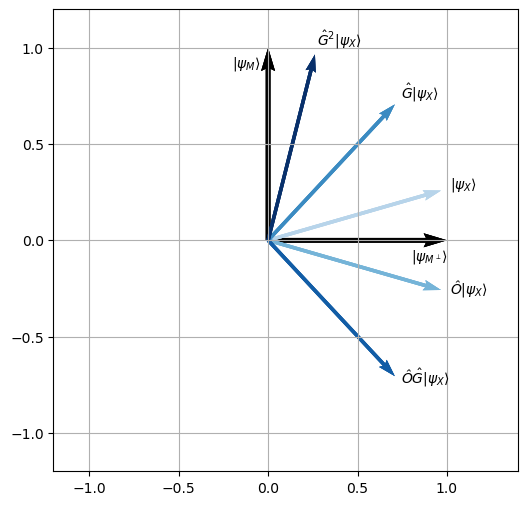

In [196]:
M = [0, 1]
M_perp = [1, 0]
delta = 0.05
origin = np.array([[0, 0, 0],[0, 0, 0]])
colors = plt.cm.get_cmap("Blues")(np.linspace(0.3, 1, len(states_arr)))

plt.figure(figsize=(6, 6))
QM = plt.quiver(*origin, *M, color="black", angles='xy', scale_units='xy', scale=1, width=0.01)
QM_perp = plt.quiver(*origin, *M_perp, color="black", angles='xy', scale_units='xy', scale=1, width=0.01)
plt.text(M[0]-0.2, M[1]-0.1, r'$|\psi_M \rangle$')
plt.text(M_perp[0]-0.2, M_perp[1]-0.1, r'$|\psi_{M^{\perp}} \rangle$')

for i in range(len(grover_iters_arr)):
    Qstate = plt.quiver(*origin, *states_arr[i], color=colors[i], angles='xy', scale_units='xy', scale=1)
    
    bs = "\\"
    if i == 0:
        label = f'$ | {bs}psi_X {bs}rangle$'
        
    elif i == 1:
        label = f'$Ô | {bs}psi_X {bs}rangle$'
        
    elif i == 2:
        label = f'${bs}hat{{G}} | {bs}psi_X {bs}rangle$'
        
    elif i == 3:
        label = f'$Ô {bs}hat{{G}} | {bs}psi_X {bs}rangle$'
        
        
    elif i%2 == 0:
        k = int(grover_iters_arr[i]/2)
        label = f'${bs}hat{{G}}^{k} | {bs}psi_X {bs}rangle$'
        
    else:
        k=int((grover_iters_arr[i]-1)/2)        
        label = f'$Ô {bs}hat{{G}}^{k} |{bs}psi_X {bs}rangle$'
    plt.text(states_arr[i][0]*1.05, states_arr[i][1]*1.05, label)

plt.ylim(-1.2, 1.2)
plt.xlim(-1.2, 1.4)
plt.grid()
# plt.xlabel(r'$|\psi_{M^{\perp}} \rangle$')
# plt.ylabel(r'$|\psi_{M} \rangle$')
plt.show()

In [192]:
def get_angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))


print(get_angle(states_arr[0], np.array([1, 0])))
print(get_angle(states_arr[0], states_arr[2]))
print(get_angle(states_arr[2], states_arr[4]))
print(get_angle(states_arr[1], states_arr[3]))
print(get_angle(states_arr[3], states_arr[5]))


0.2611574109030244
0.5223148218060482
0.5223148218060468
0.5223148218060482
0.5223148218060473


## Plot of scaling of number of qubits with number of hits

In [161]:
def total_qbits_from_hits(n_hits):
    n = np.ceil(np.log2(n_hits))
    n_qbits = 5*n + 2
    return n_qbits

Text(0, 0.5, 'Number of qubits')

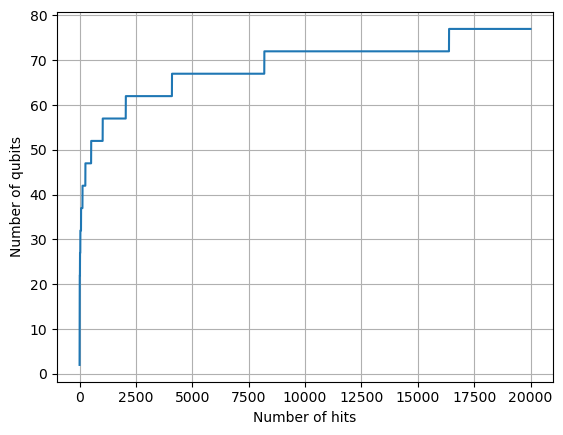

In [162]:
n_hits = np.arange(1, 20000)

plt.plot(n_hits, total_qbits_from_hits(n_hits))
plt.grid()
plt.xlabel("Number of hits")
plt.ylabel("Number of qubits")

In [172]:
n_hits = 10000
print(f"For a set of {n_hits} hits, we would require {total_qbits_from_hits(n_hits)} qubits ")
print(r"Scales as O(5*log_2(n))")

For a set of 10000 hits, we would require 72.0 qubits 
Scales as O(5*log_2(n))
